In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import seaborn as sns

In [68]:
train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [69]:
train.isnull().sum()

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                163688
V_WIND                163688
AIR_TEMPERATURE       164630
BN                    163688
ATA_LT                     0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

In [70]:
# 결측치 처리
train = train.drop(columns=['U_WIND','V_WIND','AIR_TEMPERATURE','BN'])
test = test.drop(columns=['U_WIND','V_WIND','AIR_TEMPERATURE','BN'])

In [71]:
# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

<ipython-input-71-5862de8fb0ea>:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.fillna(train.mean(), inplace=True)
<ipython-input-71-5862de8fb0ea>:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  test.fillna(train.mean(), inplace=True)


종속변수 대기시간 분포 확인

In [72]:
train['CI_HOUR'].describe()

count    391939.000000
mean         61.940835
std         170.809558
min           0.000000
25%           0.000000
50%           7.944444
75%          49.176111
max        2159.130556
Name: CI_HOUR, dtype: float64

<ipython-input-73-0b56816bbd69>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train['CI_HOUR'], shade=True)  # 밀도 그림 그리기
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(by

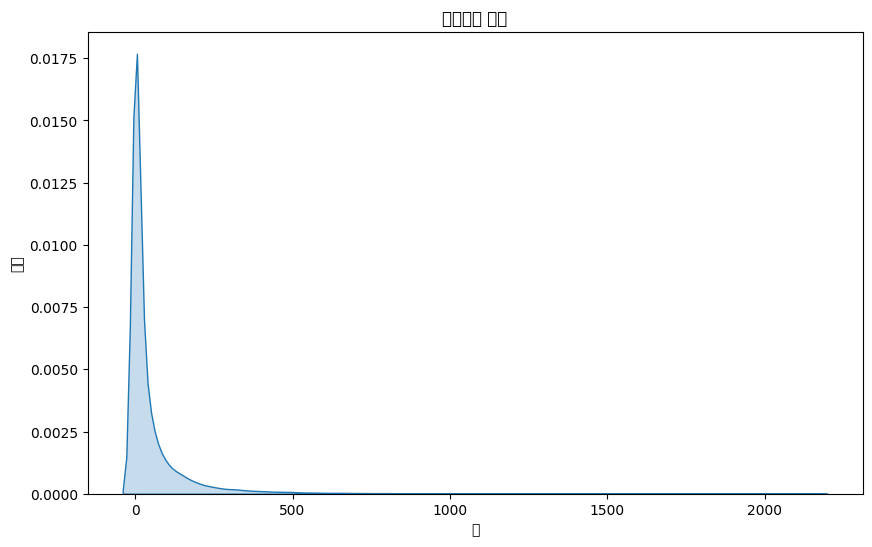

In [73]:
import seaborn as sns
# 밀도 그림 그리기
plt.figure(figsize=(10, 6), dpi=100)  # 크기와 해상도 설정
sns.kdeplot(train['CI_HOUR'], shade=True)  # 밀도 그림 그리기
plt.title('대기시간 분포')  # 그래프 제목 설정
plt.xlabel('값')  # x축 레이블 설정
plt.ylabel('빈도')  # y축 레이블 설정

plt.show()  # 그래프 표시


In [74]:
# 'CI_HOUR' 열의 평균과 표준 편차 계산
mean = train['CI_HOUR'].mean()
std = train['CI_HOUR'].std()

# 이상치 경계 설정 (예: 평균에서 2배 표준 편차를 벗어나는 값)
lower_bound = mean - 2 * std
upper_bound = mean + 2 * std

In [75]:
# 이상치 갯수
print(train[train['CI_HOUR'] < lower_bound].shape)
print(train[train['CI_HOUR'] > upper_bound].shape)

(0, 18)
(12122, 18)


In [76]:
# 이상치 3% 제거
12122/391939*100

3.0928282207180198

# filtered_train으로 **변경**

In [77]:
# 이상치를 제거하고 정상 범위의 데이터만 남김
filtered_train = train[(train['CI_HOUR'] >= lower_bound) & (train['CI_HOUR'] <= upper_bound)]

종속변수와 독립변수 상관성 확인

In [78]:
filtered_train.drop(columns='CI_HOUR').columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ATA', 'ID',
       'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'ATA_LT', 'PORT_SIZE'],
      dtype='object')

<ipython-input-80-45e0108d9193>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = selected_data.corr()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 55176 (\N{HANGUL SYLLABLE HI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) mis

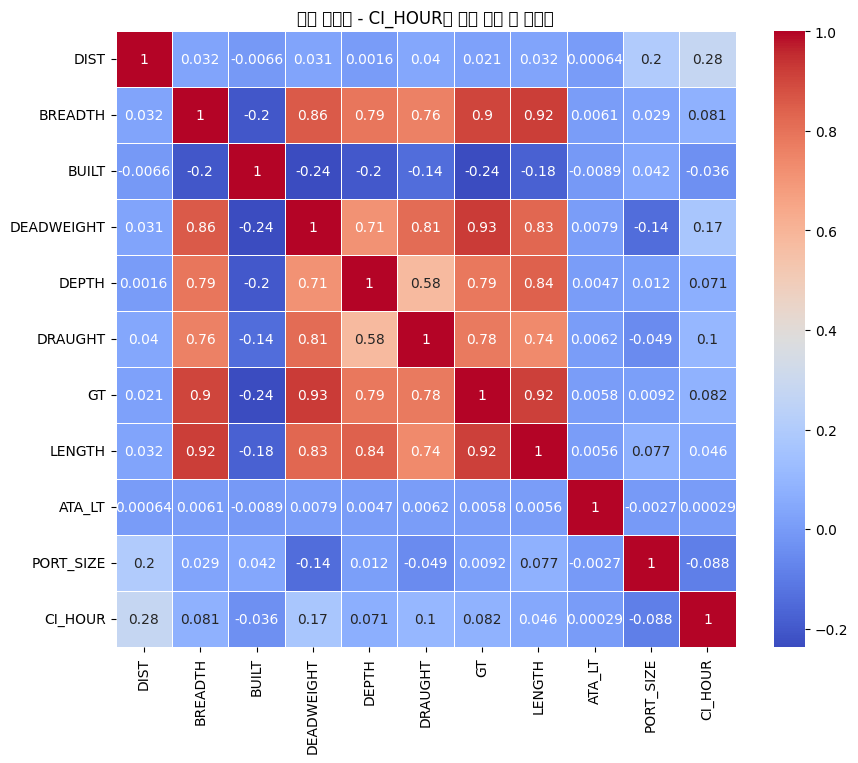

In [80]:
# 데이터프레임에서 특정 열과 다른 열들을 선택
selected_columns = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ATA', 'ID',
       'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'ATA_LT', 'PORT_SIZE','CI_HOUR']  # 특정 열과 비교할 다른 열들

# 선택한 열들로 새로운 데이터프레임 생성
selected_data = filtered_train[selected_columns]

# 상관 행렬 계산
correlation_matrix = selected_data.corr()

# 상관 히트맵 그리기
plt.figure(figsize=(10, 8))  # 그래프 크기 설정
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)  # 상관 히트맵 그리기
plt.title(f'상관 히트맵 - {selected_column}과 다른 열들 간 상관성')  # 그래프 제목 설정
plt.show()


독립변수간의 다중공선성 의심

In [86]:
filtered_train.head(1)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,SHIPMANAGER,FLAG,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,10.0,10.0,16700,180.0,CQSB78,Panama,5,0.002615,3.45


In [87]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 데이터프레임에서 독립 변수들을 선택
X = filtered_train.drop(columns = ['CI_HOUR','ARI_CO','ARI_PO','SHIP_TYPE_CATEGORY','ATA','ID','SHIPMANAGER','FLAG'])

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 결과 출력
print(vif_data)

     Variable        VIF
0        DIST   1.461710
1     BREADTH  66.059433
2       BUILT   5.260721
3  DEADWEIGHT  21.010263
4       DEPTH  28.675392
5     DRAUGHT  20.200539
6          GT  25.317540
7      LENGTH  93.812200
8      ATA_LT   3.845026
9   PORT_SIZE   2.713836


BREADTH/DEADWEIGHT/DEPTH/DRAUGHT/GT/LENGTH 다중공선성 **있는듯**

근데 문자열은 제외하고 숫자열만 있을 때라 인코딩 작업 후 다시 검사해봐야함

데이터 열 하나씩 살펴보기

In [39]:
filtered_train.columns

Index(['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'DIST', 'ATA', 'ID',
       'BREADTH', 'BUILT', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT', 'GT', 'LENGTH',
       'SHIPMANAGER', 'FLAG', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN',
       'ATA_LT', 'PORT_SIZE', 'CI_HOUR'],
      dtype='object')

ARI_CO

In [89]:
filtered_train['ARI_CO'].value_counts()

CN    139499
JP     51579
SG     40535
TW     32282
AU     31632
IN     15839
RU     13508
CA     10520
KR     10505
BR      8339
ID      5654
US      4260
UA      3120
LV      2081
MZ      2034
QA      1759
ZA      1645
VN      1510
TT      1150
PE       856
MY       831
FI       251
CL       248
PH        93
VE        87
Name: ARI_CO, dtype: int64

In [93]:
# 국가별 대기시간 평균 확인
# train 데이터프레임을 'ARI_CO' 열을 기준으로 그룹화하고 'CI_HOUR'의 평균을 계산
average_ci_hour_by_country = filtered_train.groupby('ARI_CO')['CI_HOUR'].mean()

average_ci_hour_by_country = pd.DataFrame(average_ci_hour_by_country.sort_values(ascending=False))

# 결과 출력
print(average_ci_hour_by_country)

           CI_HOUR
ARI_CO            
BR      102.658580
AU       79.076699
ZA       73.842185
PE       68.308833
CL       62.461950
MZ       59.751359
CA       57.936182
VE       54.798062
MY       45.771473
RU       44.272137
TT       39.629556
US       39.495956
SG       36.614218
UA       34.940286
CN       33.442653
IN       33.043556
VN       28.704342
ID       27.892822
FI       26.922208
QA       25.305889
JP       24.950503
LV       19.267040
PH       18.658763
KR       16.575135
TW       14.105455


ARI_PO

In [129]:
average_ci_hour_by_docks = filtered_train.groupby('ARI_PO')['CI_HOUR'].mean().reset_index()

In [130]:
average_ci_hour_by_docks

,ARI_PO,CI_HOUR
0,AIB7,37.851285
1,AZU6,41.307381
2,BAZ5,62.349167
3,BGD2,19.463737
4,BGX4,55.775667
...,...,...
98,YDP4,84.883776
99,YFK5,127.548790
100,YRT6,80.058591
101,ZAG4,25.374110


In [131]:
average_ci_hour_by_docks = pd.DataFrame(average_ci_hour_by_docks.sort_values(by='CI_HOUR',ascending=False).reset_index())
average_ci_hour_by_docks

,index,ARI_PO,CI_HOUR
0,37,KSF1,138.408962
1,99,YFK5,127.548790
2,76,TMW2,117.418942
3,86,VFD8,113.596977
4,47,NQO4,90.085527
...,...,...,...
98,51,OOV8,6.430308
99,58,PUF3,2.485537
100,29,JDG8,1.711345
101,44,NCU8,0.770950


In [133]:
 filtered_train[['ARI_CO','ARI_PO']]

,ARI_CO,ARI_PO
0,SG,GIW5
1,IN,UJM2
2,CN,EUC8
3,JP,ZAG4
4,SG,GIW5
...,...,...
391934,JP,QYY1
391935,SG,GIW5
391936,US,QGN3
391937,TW,JWI3


In [4]:
# 선박 종류는 4가지
train['SHIP_TYPE_CATEGORY'].unique()

array(['Bulk', 'Container', 'Cargo', 'Tanker'], dtype=object)

In [5]:
train['SHIP_TYPE_CATEGORY'].value_counts()

Container    155880
Bulk         154066
Cargo         38229
Tanker        19266
Name: SHIP_TYPE_CATEGORY, dtype: int64

선박 종류에 따른 대기시간 비교

In [ ]:
train_bulk = train[train['SHIP_TYPE_CATEGORY']=='Bulk']
train_container = train[train['SHIP_TYPE_CATEGORY']=='Container']
train_cargo = train[train['SHIP_TYPE_CATEGORY']=='Cargo']
train_tanker = train[train['SHIP_TYPE_CATEGORY']=='Tanker']

In [ ]:
train_bulk['CI_HOUR'].describe()

count    154066.000000
mean         79.381234
std         159.490869
min           0.000000
25%           0.000000
50%          25.550417
75%          92.669097
max        2152.193889
Name: CI_HOUR, dtype: float64

In [ ]:
train_container['CI_HOUR'].describe()

count    155880.000000
mean         39.633705
std         164.614951
min           0.000000
25%           0.000000
50%           0.000000
75%          18.330903
max        2158.901944
Name: CI_HOUR, dtype: float64

In [ ]:
train_cargo['CI_HOUR'].describe()

count    38229.000000
mean        74.450962
std        209.643412
min          0.000000
25%          0.000000
50%          7.937222
75%         45.895556
max       2159.130556
Name: CI_HOUR, dtype: float64

In [ ]:
train_tanker['CI_HOUR'].describe()

count    19266.000000
mean        76.920637
std        195.073865
min          0.000000
25%          0.000000
50%         18.014028
75%         65.990139
max       2158.467500
Name: CI_HOUR, dtype: float64

컨테이너 선박이 유난히 평균 대기시간이 적어서 원인 탐색

In [ ]:
# 선박의 재화중량톤수
print(train_container['DEADWEIGHT'].mean())
print(train_bulk['DEADWEIGHT'].mean())
print(train_cargo['DEADWEIGHT'].mean())
print(train_tanker['DEADWEIGHT'].mean())

47611.040351552474
98435.88228421586
9997.14117554736
20541.086888819682


In [ ]:
# 선박의 깊이
print(train_container['DEPTH'].mean())
print(train_bulk['DEPTH'].mean())
print(train_cargo['DEPTH'].mean())
print(train_tanker['DEPTH'].mean())

16.453554015909674
18.75923305596303
10.426912210944858
10.412124987023773


In [ ]:
# 흘수 높이
print(train_container['DRAUGHT'].mean())
print(train_bulk['DRAUGHT'].mean())
print(train_cargo['DRAUGHT'].mean())
print(train_tanker['DRAUGHT'].mean())

10.880292532717474
12.868640712421948
6.654807994140421
7.300944669365722


In [ ]:
# 선박의 길이
print(train_container['LENGTH'].mean())
print(train_bulk['LENGTH'].mean())
print(train_cargo['LENGTH'].mean())
print(train_tanker['LENGTH'].mean())

219.5199512445471
225.84580634273624
107.57638380244846
116.31371327727604


In [ ]:
# 선박 폭
print(train_container['BREADTH'].mean())
print(train_bulk['BREADTH'].mean())
print(train_cargo['BREADTH'].mean())
print(train_tanker['BREADTH'].mean())

31.23242237618681
34.47944387470305
17.288898189808517
19.923180732897332


대기시간 확인

In [ ]:
train['CI_HOUR'].describe()

count    367441.000000
mean         61.877118
std         170.575224
min           0.000000
25%           0.000000
50%           7.949444
75%          49.153333
max        2159.130556
Name: CI_HOUR, dtype: float64

<ipython-input-49-a9339b85d2b5>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train['CI_HOUR'], shade=True)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51032 (\N{HANGUL SYLLABLE YI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw

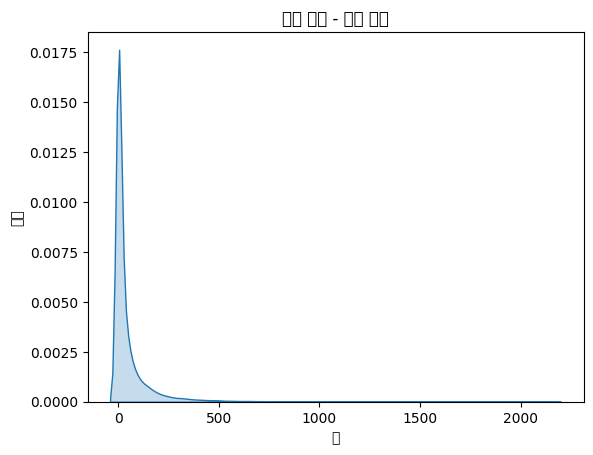

In [ ]:
# 데이터프레임의 열에서 밀도 그림 그리기
sns.kdeplot(train['CI_HOUR'], shade=True)
plt.xlabel('값')
plt.ylabel('밀도')
plt.title('값의 분포 - 밀도 그림')
plt.show()

In [ ]:
train['CI_HOUR'].isnull().sum()
# 결측치 딱 한개 존재

0

In [ ]:
# 데이터 분할
filtered_75 = train[(train['CI_HOUR'] > train['CI_HOUR'].quantile(0.75))]

In [ ]:
print(filtered_75['ARI_CO'].value_counts())

CN    30416
AU    16195
SG    10751
JP     7899
BR     5415
RU     3968
CA     3729
IN     3357
TW     2631
KR     1135
US     1114
ID      943
UA      852
MZ      764
ZA      763
PE      350
VN      313
QA      289
TT      278
LV      274
MY      240
CL      106
FI       35
VE       35
PH        8
Name: ARI_CO, dtype: int64


In [ ]:
filtered_75['ARI_PO'].value_counts()

GIW5    10751
WHH4     5517
NGG6     5039
EKP8     4712
EUC8     4580
        ...  
XZF6        8
ONW1        7
DIN2        7
PUF3        6
RKA2        4
Name: ARI_PO, Length: 102, dtype: int64

나라별 들어온 선박 수

['CN' 'JP' 'RU' 'AU' 'SG' 'ZA' 'KR' 'TW' 'TT' 'ID' 'BR' 'QA' 'LV' 'MZ'
 'US' 'IN' 'UA' 'CA' 'MY' 'PE' 'VN' 'FI' 'CL' 'VE' 'PH']
CN    132739
JP     49454
SG     41214
AU     30912
TW     30600
IN     15140
RU     13498
CA     10147
KR      9983
BR      8811
ID      5506
US      4130
UA      3161
MZ      1994
LV      1991
QA      1694
ZA      1560
VN      1486
TT      1110
PE       842
MY       795
CL       256
FI       244
VE        89
PH        85
Name: ARI_CO, dtype: int64


<ipython-input-54-805168bbee74>:18: UserWarning: Glyph 45208 (\N{HANGUL SYLLABLE NA}) missing from current font.
  plt.tight_layout()
<ipython-input-54-805168bbee74>:18: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  plt.tight_layout()
<ipython-input-54-805168bbee74>:18: UserWarning: Glyph 49440 (\N{HANGUL SYLLABLE SEON}) missing from current font.
  plt.tight_layout()
<ipython-input-54-805168bbee74>:18: UserWarning: Glyph 48149 (\N{HANGUL SYLLABLE BAG}) missing from current font.
  plt.tight_layout()
<ipython-input-54-805168bbee74>:18: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  plt.tight_layout()
<ipython-input-54-805168bbee74>:18: UserWarning: Glyph 54943 (\N{HANGUL SYLLABLE HOES}) missing from current font.
  plt.tight_layout()
<ipython-input-54-805168bbee74>:18: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
<ipython-input-54-805168bbee74>:18: UserWarning: Glyph

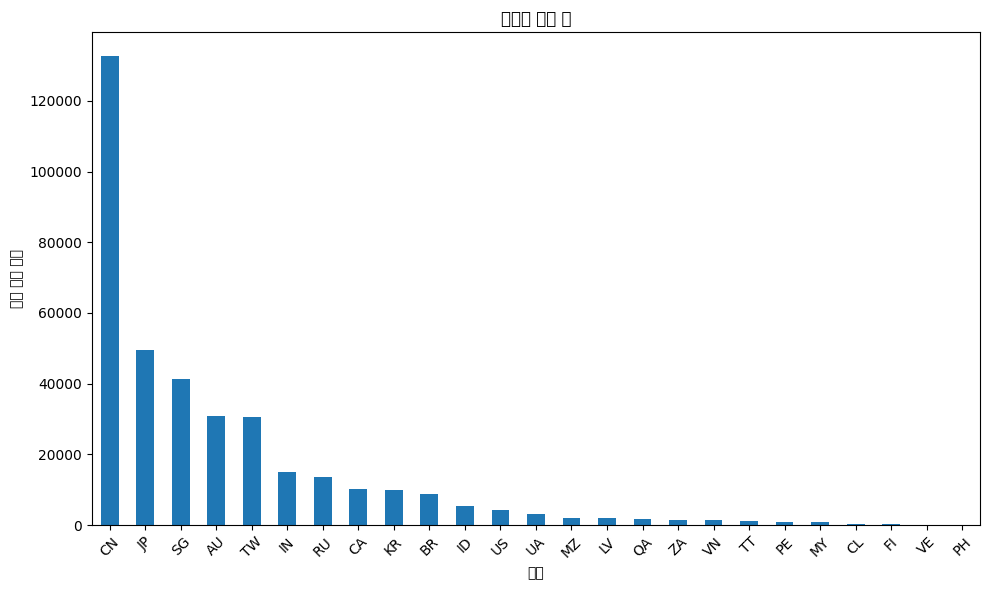

In [ ]:
# 도착항 소속 국가 종류
print(train['ARI_CO'].unique())
print(train['ARI_CO'].value_counts())

# 데이터프레임에서 'ARI_CO' 열의 값을 카운트
value_counts = train['ARI_CO'].value_counts()

# 막대 그래프
plt.figure(figsize=(10, 6))

value_counts.plot(kind='bar')
plt.xlabel('나라')
plt.ylabel('선박 정박 횟수')
plt.title('나라별 정박 수')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

 중국 항구별 들어온 선박 수

In [ ]:
train_cn = train[train['ARI_CO']=='CN'].reset_index()
train_cn

,index,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,1,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,2,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,5,CN,NGG6,Container,81.435335,2015-09-08 14:24,Z156413,30.0,22,18100,...,NaN,NaN,NaN,22,45.75,48.89,45.92,820.288044,0.001743,42.078056
4,10,CN,EKP8,Container,32.565205,2018-08-14 3:33,B336786,30.0,23,25600,...,NaN,NaN,NaN,11,70.66,70.76,65.01,1610.724314,0.001660,31.891944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132734,367427,CN,WEY7,Container,13.693997,2015-12-23 5:28,T871888,20.0,9,6100,...,NaN,NaN,NaN,13,32.19,37.28,37.04,471.884296,0.001028,186.698889
132735,367428,CN,YRT6,Bulk,37.195803,2017-11-28 14:03,R434648,30.0,8,47800,...,NaN,NaN,NaN,22,60.99,62.45,57.47,1574.233684,0.000360,141.522500
132736,367434,CN,QQW1,Bulk,55.408765,2022-06-16 14:27,D236761,30.0,16,26500,...,0.96,28.2,2.651752,22,108.43,114.13,109.56,2067.433444,0.000595,83.960833
132737,367436,CN,YRT6,Bulk,59.018184,2017-11-11 22:23,J661243,40.0,13,93200,...,NaN,NaN,NaN,6,61.25,62.21,55.70,1333.609109,0.000360,65.850000


In [ ]:
print(train_cn['ARI_PO'].unique())
print(train_cn['ARI_PO'].value_counts())

['EKP8' 'EUC8' 'NGG6' 'QQW1' 'WEY7' 'UVK6' 'JEN5' 'YRT6' 'NCU8' 'JTD1'
 'TDA5' 'WAF5' 'XVZ3' 'TXO3' 'BGX4' 'SXD2' 'FTQ1' 'JDG8' 'RGT8']
NGG6    27243
EUC8    21263
EKP8    18465
NCU8    10253
WEY7     7992
JEN5     7959
JTD1     7056
QQW1     6791
YRT6     6695
TDA5     6146
XVZ3     3349
UVK6     2470
TXO3     2422
WAF5     2083
SXD2     1012
BGX4      882
JDG8      341
FTQ1      311
RGT8        6
Name: ARI_PO, dtype: int64


In [ ]:
train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,DUBAI,BRENT,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR
0,CN,EKP8,Bulk,30.736578,2020-10-15 4:03,Z517571,30.0,28,73100,20.0,...,3.77,15.9,2.730798,12,42.01,43.16,40.96,1407.668330,0.001660,3.048333
1,CN,EUC8,Container,63.220425,2019-09-17 2:55,U467618,30.0,15,37900,20.0,...,-6.72,24.5,4.289058,10,67.53,64.55,59.34,2089.046774,0.001614,17.138611
2,CN,NGG6,Container,90.427421,2019-02-23 6:43,V378315,50.0,7,115000,20.0,...,0.00,9.4,0.000000,14,65.30,66.39,56.94,603.193047,0.001743,98.827500
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06,B726632,10.0,33,1490,10.0,...,-7.31,22.1,4.693735,7,43.02,43.15,41.11,1169.853455,0.000069,0.000000
4,RU,NNC2,Container,8.813725,2022-08-13 12:57,D215135,30.0,10,27600,10.0,...,2.31,22.8,2.345875,14,90.45,93.65,88.11,1107.944894,0.000197,96.030556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,CN,YRT6,Bulk,59.018184,2017-11-11 22:23,J661243,40.0,13,93200,20.0,...,NaN,NaN,NaN,6,61.25,62.21,55.70,1333.609109,0.000360,65.850000
367437,JP,QYY1,Tanker,0.000000,2022-04-29 2:58,D847216,10.0,9,1280,0.0,...,0.87,17.1,1.028558,11,105.37,109.34,104.69,1955.103846,0.000552,0.000000
367438,SG,GIW5,Container,1.768630,2022-07-14 7:58,Q635545,30.0,6,25000,20.0,...,3.36,31.7,2.557156,15,97.73,99.10,95.78,1601.291086,0.002615,0.997500
367439,JP,TMR7,Cargo,0.000000,2020-12-22 10:07,N211282,10.0,8,2400,10.0,...,-2.44,10.8,3.055715,19,49.75,50.08,47.02,1191.353331,0.000069,0.000000


In [ ]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
# datetime을 여러 파생 변수로 변환
train['year'] = train['ATA'].dt.year
train['month'] = train['ATA'].dt.month
train['day'] = train['ATA'].dt.day
train['hour'] = train['ATA'].dt.hour
train['minute'] = train['ATA'].dt.minute
train['weekday'] = train['ATA'].dt.weekday

In [ ]:
train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,WTI,BDI_ADJ,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
0,CN,EKP8,Bulk,30.736578,2020-10-15 04:03:00,Z517571,30.0,28,73100,20.0,...,40.96,1407.668330,0.001660,3.048333,2020,10,15,4,3,3
1,CN,EUC8,Container,63.220425,2019-09-17 02:55:00,U467618,30.0,15,37900,20.0,...,59.34,2089.046774,0.001614,17.138611,2019,9,17,2,55,1
2,CN,NGG6,Container,90.427421,2019-02-23 06:43:00,V378315,50.0,7,115000,20.0,...,56.94,603.193047,0.001743,98.827500,2019,2,23,6,43,5
3,JP,TMR7,Cargo,0.000000,2020-09-18 22:06:00,B726632,10.0,33,1490,10.0,...,41.11,1169.853455,0.000069,0.000000,2020,9,18,22,6,4
4,RU,NNC2,Container,8.813725,2022-08-13 12:57:00,D215135,30.0,10,27600,10.0,...,88.11,1107.944894,0.000197,96.030556,2022,8,13,12,57,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367436,CN,YRT6,Bulk,59.018184,2017-11-11 22:23:00,J661243,40.0,13,93200,20.0,...,55.70,1333.609109,0.000360,65.850000,2017,11,11,22,23,5
367437,JP,QYY1,Tanker,0.000000,2022-04-29 02:58:00,D847216,10.0,9,1280,0.0,...,104.69,1955.103846,0.000552,0.000000,2022,4,29,2,58,4
367438,SG,GIW5,Container,1.768630,2022-07-14 07:58:00,Q635545,30.0,6,25000,20.0,...,95.78,1601.291086,0.002615,0.997500,2022,7,14,7,58,3
367439,JP,TMR7,Cargo,0.000000,2020-12-22 10:07:00,N211282,10.0,8,2400,10.0,...,47.02,1191.353331,0.000069,0.000000,2020,12,22,10,7,1
